# Implementing DRL for Automated Stock Trading

## Python environment

In [4]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-m45mfbwz
  Running command git clone -q https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-m45mfbwz
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-gx2ap7xw/pyfolio_4e67752ac4a04db19f7f9e905ff54a49
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-gx2ap7xw/pyfolio_4e67752ac4a04db19f7f9e905ff54a49
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-gx2ap7xw/elegantrl_159e31e9a40f47dca89e884370c2f8e3
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-gx2ap7xw/elegantrl_159e31e9a40f47dca89e884370c2f8e3


## Datasets

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [60]:
sentiment = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Combined_News_DJIA.csv')

In [62]:
sentiment.info()
sentiment.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1989 non-null   object
 1   Label   1989 non-null   int64 
 2   Top1    1989 non-null   object
 3   Top2    1989 non-null   object
 4   Top3    1989 non-null   object
 5   Top4    1989 non-null   object
 6   Top5    1989 non-null   object
 7   Top6    1989 non-null   object
 8   Top7    1989 non-null   object
 9   Top8    1989 non-null   object
 10  Top9    1989 non-null   object
 11  Top10   1989 non-null   object
 12  Top11   1989 non-null   object
 13  Top12   1989 non-null   object
 14  Top13   1989 non-null   object
 15  Top14   1989 non-null   object
 16  Top15   1989 non-null   object
 17  Top16   1989 non-null   object
 18  Top17   1989 non-null   object
 19  Top18   1989 non-null   object
 20  Top19   1989 non-null   object
 21  Top20   1989 non-null   object
 22  Top21   1989 non-null   

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [54]:
stock_data = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-11-12',
                     ticker_list = config.DOW_30_TICKER).fetch_data()
stock_data.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [41]:
stock_data.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.778781,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.998848,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.618543,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.475803,7117200,CAT,4


In [42]:
stock_data.tail()

,date,open,high,low,close,volume,tic,day
94596,2021-11-11,460.000000,460.850006,455.440002,457.390015,2246800,UNH,3
94597,2021-11-11,216.470001,216.779999,210.160004,210.419998,13546900,V,3
94598,2021-11-11,52.740002,52.740002,52.360001,52.450001,10983700,VZ,3
94599,2021-11-11,49.389999,49.959999,49.080002,49.461998,3837200,WBA,3
94600,2021-11-11,148.770004,148.990005,148.190002,148.500000,4534400,WMT,3


In [43]:
stock_data.shape

(94601, 8)

In [44]:
stock_data.tic.value_counts()

CAT     3239
INTC    3239
NKE     3239
MSFT    3239
TRV     3239
V       3239
KO      3239
GS      3239
BA      3239
HD      3239
WBA     3239
CVX     3239
AMGN    3239
MCD     3239
VZ      3239
JPM     3239
HON     3239
UNH     3239
AAPL    3239
WMT     3239
MMM     3239
AXP     3239
CSCO    3239
IBM     3239
MRK     3239
JNJ     3239
PG      3239
CRM     3239
DIS     3239
DOW      670
Name: tic, dtype: int64

## Preprocessing

  - Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
  - Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.


In [45]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(stock_data)

Successfully added technical indicators
Successfully added turbulence index


In [46]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
41868,2014-09-26,43.990002,44.994999,43.650002,41.494568,35090400,NKE,4,0.540908,39.822732,35.655638,69.535724,373.390697,62.436756,37.325335,36.579803,237.058319
82036,2020-03-30,242.639999,254.089996,242.639999,245.638397,5329000,UNH,0,-10.574390,297.872318,188.244454,47.982925,-26.797426,3.922265,252.791792,268.179124,119.598538
70893,2018-09-18,158.169998,159.080002,157.580002,146.846939,3722800,MCD,1,0.384873,154.651279,145.843593,46.474524,-92.898985,26.566915,149.378198,147.771590,15.620435
90452,2021-05-25,246.660004,247.750000,241.779999,240.145599,3210600,AMGN,1,0.242889,256.726523,233.657474,47.717319,-95.777346,10.603107,247.453609,242.705515,10.737832
37527,2014-02-25,125.339996,126.220001,124.019997,102.235619,2416300,AMGN,1,1.699847,105.069361,93.368045,58.420958,120.199699,33.355120,98.749410,96.025641,43.038601


## Design Environment

Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [47]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [48]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

## DRL algorithm


  - The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

  - FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to design their own DRL algorithms by adapting these DRL algorithms.

  - In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method (reference code)


In [49]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2020-04-01'
val_test_start = '2020-04-01'
val_test_end = '2021-11-12'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [50]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [51]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  200.92920980699603
======Model training from:  2009-01-01 to  2020-04-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_2
--------------------------------------
| time/                 |            |
|    fps                | 99         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.128     |
|    learning_rate      | 0.0005     |
|    n_updates          | 99         |
|    policy_loss        | -78.3      |
|    reward             | 0.21270886 |
|    std                | 1          |
|    value_loss         | 4.58       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps     

## Backtesting

In [56]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [57]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.048220330697135


In [58]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-07-02,NaN,2020-07-02
1,1.004077e+06,2020-07-06,0.004077,2020-07-06
2,9.966314e+05,2020-07-07,-0.007415,2020-07-07
3,1.000185e+06,2020-07-08,0.003566,2020-07-08
4,9.866558e+05,2020-07-09,-0.013527,2020-07-09


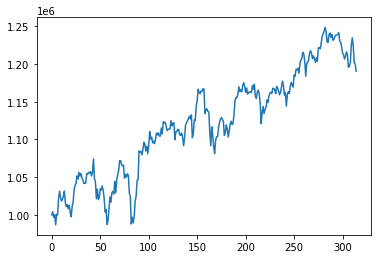

In [59]:
%matplotlib inline
df_account_value.account_value.plot()

In [63]:

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.149632
Cumulative returns     0.190415
Annual volatility      0.143261
Sharpe ratio           1.048220
Calmar ratio           1.850228
Stability              0.894701
Max drawdown          -0.080872
Omega ratio            1.196029
Sortino ratio          1.496490
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.998555
Daily value at risk   -0.017453
dtype: float64


In [64]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
Annual return          0.258363
Cumulative returns     0.331562
Annual volatility      0.140342
Sharpe ratio           1.713529
Calmar ratio           2.892948
Stability              0.932726
Max drawdown          -0.089308
Omega ratio            1.329843
Sortino ratio          2.527515
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.055997
Daily value at risk   -0.016727
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)


Start date,2020-07-02
End date,2021-09-30
Total months,15
,Backtest
Annual return,14.963%
Cumulative returns,19.042%
Annual volatility,14.326%
Sharpe ratio,1.05
Calmar ratio,1.85
Stability,0.89
Max drawdown,-8.087%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.09,2020-09-02,2020-09-23,2020-11-09,49
1,7.38,2021-02-16,2021-03-04,2021-04-09,39
2,4.67,2021-08-16,2021-09-30,NaT,NaN
3,4.62,2021-04-16,2021-05-12,2021-06-14,42
4,3.29,2020-07-22,2020-07-31,2020-08-05,11


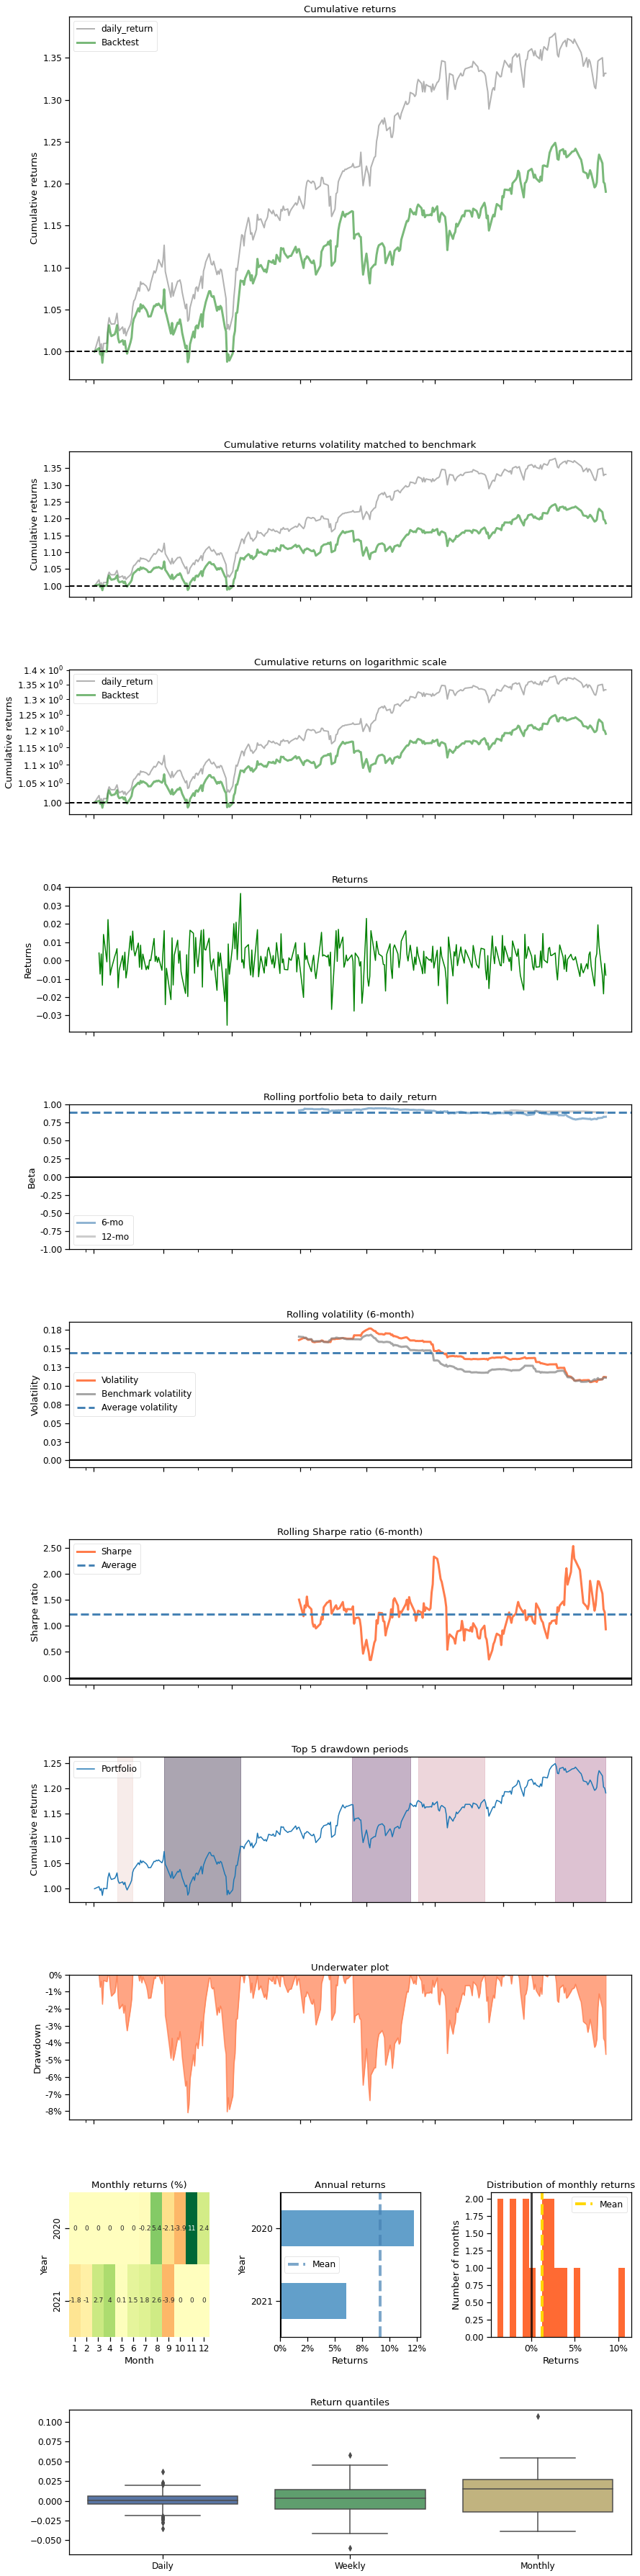

In [65]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])